In [18]:
import os
import numpy as np
from mtf.calculate_mtf import calc_mtf

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-05_CT_metal_artifact'

sub = 'water_only'
good_slices = [11, 12]  # The range of slices to calculate the MTF from
bin_num = -1  # The bin number to calculate the MTF in
bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])


freq = 1 / (2 * bar_size)
num_slices = (good_slices[1] + 1) - good_slices[0]
# Load just the desired bin and slices
data = np.load(os.path.join(directory, folder, sub, 'Norm CT', 'CT_norm.npy'))[bin_num, good_slices[0]:good_slices[1]+1]

# Load the desired masks
mtf_masks = np.load(os.path.join(directory, folder, sub, 'masks_mtf.npy'))
mat1_mask = np.load(os.path.join(directory, folder, sub, 'phantom_mask_mtf.npy'))
mat2_mask = np.load(os.path.join(directory, folder, sub, 'air_mtf.npy'))

num_rois = len(mtf_masks)  # The number of masks or rois to calculate the noise within

mtf_vals = np.zeros((num_slices, num_rois))
for z in range(num_slices):

    mat1_data = data[z] * mat1_mask
    mat2_data = data[z] * mat2_mask

    # Mean and std of the two materials of the bar pattern
    mean_mat1 = np.nanmean(mat1_data)
    std_mat1 = np.nanstd(mat1_data)
    mean_mat2 = np.nanmean(mat2_data)
    std_mat2 = np.nanstd(mat2_data)

    std_rois = np.zeros(num_rois)
    for roi in range(num_rois):
        std_rois[roi] = np.nanstd(data[z] * mtf_masks[roi])

    # Calculate the MTF from the above values
    mtf_vals[z] = calc_mtf(std_rois, mean_mat1, mean_mat2, std_mat1, std_mat2)

# Average and take the std of the the mtf values over the slices
std_mtf = np.std(mtf_vals, axis=0)
mean_mtf = np.mean(mtf_vals, axis=0)

MTF = np.array([freq, mean_mtf, std_mtf])

np.save(os.path.join(directory, folder, sub, 'MTF_calc.npy'), MTF)

[ 0.          0.5         0.66666667  0.75757576  1.          1.51515152
  2.         10.        ]
[1.00000000e+00 5.80661360e-01 4.44811120e-01 3.72392904e-01
 2.40395978e-01 7.51315536e-02 3.06984675e-03 1.00000000e-04]
Limiting resolution: 1.09 lp/mm, 0.458 mm


c:\users\drich\pycharmprojects\reconstruction\venv\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


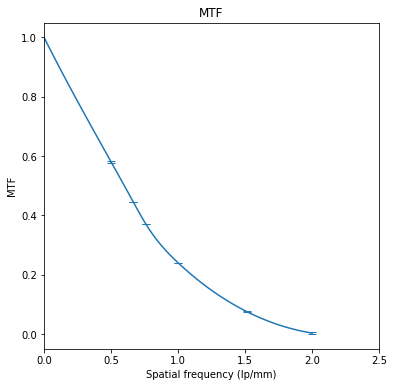

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-12_CT_metal'
sub = 'water_only'

# Do a curve fit with exponential or spline
method = 'spline'  # Either 'exp' or 'spline'

mtf = np.load(os.path.join(directory, folder, sub, 'MTF_calc.npy'))

freq = mtf[0]
mtf_mean = mtf[1]
mtf_std = mtf[2]

freq_fit = np.linspace(0, 2, 100)

if method == 'exp':
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(func, np.insert(freq, 0, 0), np.insert(mtf_mean, 0, 1))
    mtf_new = func(freq_fit, *popt)

else:
    temp_freq = np.insert(freq, 0, 0)

    temp_freq = np.insert(temp_freq, len(temp_freq), 10)
    print(temp_freq)
    mtf_temp = np.insert(mtf_mean, 0, 1)
    mtf_temp = np.insert(mtf_temp, len(mtf_temp), 0.0001)
    print(mtf_temp)

    cs = CubicSpline(temp_freq, mtf_temp)
    mtf_new = cs(freq_fit)

# Find the 0.1 spot
idx = np.abs(mtf_new - 0.2).argmin()
print(f'Limiting resolution: {freq_fit[idx]:0.2f} lp/mm, {1/(2*freq_fit[idx]):0.3f} mm')


fig = plt.figure(figsize=(6, 6))
plt.errorbar(freq, mtf_mean, yerr=mtf_std, capsize=4, fmt='none')
plt.plot(freq_fit, mtf_new)
plt.title('MTF')
plt.ylabel('MTF')
plt.xlabel('Spatial frequency (lp/mm)')
plt.xlim([0, 2.5])

fig.show()

# np.save(os.path.join(directory, folder, 'Two', 'CT_mtf_fit_2.npy'), np.array([freq_fit, mtf_new]))
# np.save(os.path.join(directory, folder, 'Two', 'CT_mtf_data_2.npy'), np.array([freq, mtf_mean, mtf_std]))

# Save the MTF
np.save(os.path.join(directory, folder, sub, 'mtf_fit.npy'), np.array([freq_fit, mtf_new]))

Limiting resolution: 1.313 lp/mm, 0.381 mm
Limiting resolution: 1.313 lp/mm, 0.381 mm
Limiting resolution: 1.313 lp/mm, 0.381 mm
Limiting resolution: 2.020 lp/mm, 0.247 mm
Limiting resolution: 1.515 lp/mm, 0.330 mm
Limiting resolution: 1.313 lp/mm, 0.381 mm


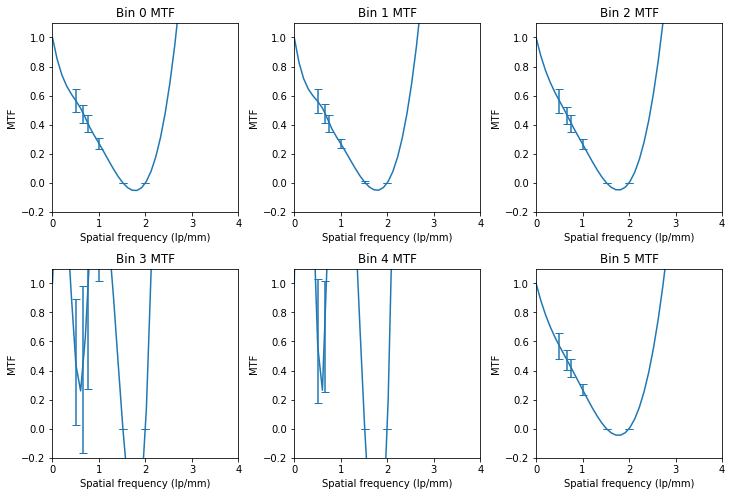

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Do a curve fit with exponential
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-05_CT_metal_artifact'

sub = 'water_only'

num_bins = 6

mtf_data = np.load(os.path.join(directory, folder, sub, 'mtf_water_contrast.npy'))

bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])
freq = 1 / (2 * bar_size)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

freq_fit = np.linspace(0, 10, 100)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i > num_bins-1:
        break
    mtf_mean = mtf_data[i, 0]
    mtf_std = mtf_data[i, 1]

    # popt, pcov = curve_fit(func, np.insert(freq, 0, 0), np.insert(mtf_mean, 0, 1))
    cs = CubicSpline(np.insert(freq, 0, 0), np.insert(mtf_mean, 0, 1))
    # Find the 0.1 spot
    # mtf_new = func(freq_fit, *popt)
    mtf_new = cs(freq_fit)
    idx = np.abs(mtf_new - 0.1).argmin()
    idx = np.abs(mtf_new - 0.1).argmin()
    print(f'Limiting resolution: {freq_fit[idx]:0.3f} lp/mm, {1/(2*freq_fit[idx]):0.3f} mm')

    ax.errorbar(freq, mtf_mean, yerr=mtf_std, capsize=4, fmt='none')
    ax.plot(freq_fit, mtf_new)
    ax.set_title(f'Bin {i} MTF')
    ax.set_ylabel('MTF')
    ax.set_xlabel('Spatial frequency (lp/mm)')
    ax.set_xlim([0, 4])
    ax.set_ylim([-0.2, 1.1])

fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()
fig.savefig(os.path.join(directory, folder, sub+'_mtf.png'), dpi=500)

c:\users\drich\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


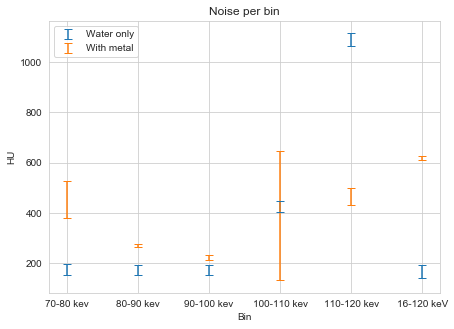

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-05_CT_metal_artifact'
water_sub = 'water_only'
sub = '2_metal_3and4'

bin_width = 1  # Multiples of 10
thresholds = [70, 80, 90, 100, 110, 120]

# Load the metal artifact data
data = np.load(os.path.join(directory, folder, sub, 'Norm CT', 'CT_norm.npy'))[:, 11:14]
num_bins = np.shape(data)[0]
noise_mtf = np.load(os.path.join(directory, folder, sub, 'noise_mtf.npy'))

# Load the water data to compare
water_data = np.load(os.path.join(directory, folder, water_sub, 'Norm CT', 'CT_norm.npy'))[:, 11:14]
noise_water_mtf = np.load(os.path.join(directory, folder, water_sub, 'noise_mtf.npy'))

noise_data = np.zeros((num_bins, 3))
noise_water = np.zeros((num_bins, 3))  # number of bins, slices
for i in range(num_bins):
    for z in range(3):
        noise_data[i, z] = np.nanstd(data[i, z]*noise_mtf)
        noise_water[i, z] = np.nanstd(water_data[i, z]*noise_water_mtf)

# Get the std of the noise over the slices
std_data = np.std(noise_data, axis=1)
std_water = np.std(noise_water, axis=1)

# Get the x tick labels
labels = []
if bin_width == 1:
    for i in range(num_bins-bin_width):
        labels.append(f'{thresholds[i]}-{thresholds[i+1]} kev')
    labels.append('16-120 keV')
else:
    for i in range(num_bins):
        labels.append(f'{thresholds[i]}-{thresholds[i+(bin_width)]} kev')

# Take the mean of the noise over the slices
noise_data = np.mean(noise_data, axis=1)
noise_water = np.mean(noise_water, axis=1)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5))
plt.errorbar(np.arange(num_bins), noise_water, yerr=std_water, capsize=4, fmt='none')
plt.errorbar(np.arange(num_bins), noise_data, yerr=std_data, capsize=4, fmt='none')
plt.xticks(np.arange(num_bins), labels)
plt.title(f'Noise per bin')
plt.legend(['Water only', 'With metal'])
plt.ylabel('HU')
plt.xlabel('Bin')


fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.show()
fig.savefig(os.path.join(directory, folder, sub+'_noise.png'), dpi=500)

c:\users\drich\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


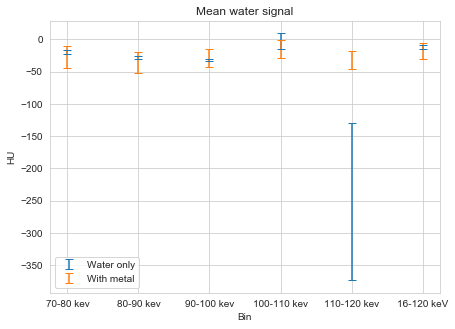

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-05-05_CT_metal_artifact'
water_sub = 'water_only'
sub = '3_metal'

bin_width = 1  # Multiples of 10
thresholds = [70, 80, 90, 100, 110, 120]

# Load the metal artifact data
data = np.load(os.path.join(directory, folder, sub, 'Norm CT', 'CT_norm.npy'))[:, 11:14]
num_bins = np.shape(data)[0]
mtf_data = np.load(os.path.join(directory, folder, sub, 'water_mtf.npy'))

# Load the water data to compare
water_data = np.load(os.path.join(directory, folder, water_sub, 'Norm CT', 'CT_norm.npy'))[:, 11:14]
mtf_water = np.load(os.path.join(directory, folder, water_sub, 'water_mtf.npy'))

mean_data = np.zeros((num_bins, 3))
mean_water = np.zeros((num_bins, 3))  # number of bins, slices
for i in range(num_bins):
    for z in range(3):
        mean_data[i, z] = np.nanmean(data[i, z]*mtf_data)
        mean_water[i, z] = np.nanmean(water_data[i, z]*mtf_water)

# Get the std of the noise over the slices
std_data = np.std(mean_data, axis=1)
std_water = np.std(mean_water, axis=1)

# Get the x tick labels
labels = []
if bin_width == 1:
    for i in range(num_bins-bin_width):
        labels.append(f'{thresholds[i]}-{thresholds[i+1]} kev')
    labels.append('16-120 keV')
else:
    for i in range(num_bins):
        labels.append(f'{thresholds[i]}-{thresholds[i+(bin_width)]} kev')

# Take the mean of the noise over the slices
mean_data = np.mean(mean_data, axis=1)
mean_water = np.mean(mean_water, axis=1)

sns.set_style('whitegrid')
fig = plt.figure(figsize=(7, 5))
plt.errorbar(np.arange(num_bins), mean_water, yerr=std_water, capsize=4, fmt='none')
plt.errorbar(np.arange(num_bins), mean_data, yerr=std_data, capsize=4, fmt='none')
plt.xticks(np.arange(num_bins), labels)
plt.title(f'Mean water signal')
plt.legend(['Water only', 'With metal'])
plt.ylabel('HU')
plt.xlabel('Bin')


fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.show()
fig.savefig(os.path.join(directory, folder, sub+'_water.png'), dpi=500)


Limiting resolution: 10.00 lp/mm, 0.050 mm


c:\users\drich\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


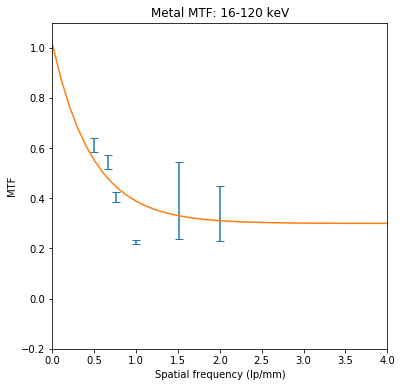

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Do a curve fit with exponential
from scipy.optimize import curve_fit

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data'
folder = '21-04-14_CT_bin_width_10'

# sub = 'water_phantom'
sub = 'metal_phantom'

bin_num = 5

mtf_data = np.load(os.path.join(directory, folder, sub, 'mtf.npy'))

bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])
freq = 1 / (2 * bar_size)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

freq_fit = np.linspace(0, 10, 100)

fig = plt.figure(figsize=(6, 6))

mtf_mean = mtf_data[bin_num, 0]
mtf_std = mtf_data[bin_num, 1]

popt, pcov = curve_fit(func, np.insert(freq, 0, 0), np.insert(mtf_mean, 0, 1))

# Find the 0.1 spot
mtf_new = func(freq_fit, *popt)
idx = np.abs(mtf_new - 0.2).argmin()
print(f'Limiting resolution: {freq_fit[idx]:0.2f} lp/mm, {1/(2*freq_fit[idx]):0.3f} mm')

plt.errorbar(freq, mtf_mean, yerr=mtf_std, capsize=4, fmt='none')
plt.plot(freq_fit, mtf_new)
plt.title('Metal MTF: 16-120 keV')
plt.ylabel('MTF')
plt.xlabel('Spatial frequency (lp/mm)')
plt.xlim([0, 4])
plt.ylim([-0.2, 1.1])

fig.show()
# fig.savefig(os.path.join(directory, folder, sub+'metal_only.png'), dpi=500)